## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

There are **294478** rows in the dataset.

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

There are **290584** unique users in the dataset.

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

The proportion of users converted is **0.119659**.

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df.query('(group == "treatment" and landing_page == "old_page") or (group == "control" and landing_page == "new_page")').count()[0]

3893

The number of times the *new_page* and *treatment* don't match is **3893** times.

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

No row has missing values.

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

We should only use the rows that we can feel confident in the accuracy of the data, so we should remove these rows.

In [8]:
indexes_to_drop = df.query('(group == "treatment" and landing_page == "old_page") or (group == "control" and landing_page == "new_page")').index.values
df2 = df.drop(indexes_to_drop)
df2.shape

(290585, 5)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

There are **290584** unique users in df2.

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


The user with id 773192 is duplicated.

c. What is the row information for the repeat **user_id**? 

In [12]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.drop(df2.query('user_id == 773192').index[0], inplace=True)

In [14]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2['converted'].mean()

0.11959708724499628

The probability of an individual converting regardless of the page they receive is **0.119597**.

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

The probability that a member from the *control* group converted is **0.120386**.

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

The probability that a member from the *treatment* group converted is **0.118808**.

d. What is the probability that an individual received the new page?

In [18]:
(df2['landing_page'] == 'new_page').mean()

0.50006194422266881

The probability that an individual received the new page is **0.500062**.

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

The difference between users converted from treatment group and from control group is very small (advantage to the control group). The proportions of each page are aproximately equivalent. There is no sufficient evidence to conclude that the new treatment page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$ H_0 : p_{new} \leq p_{old} $$
$$ H_1 : p_{new} > p_{old} $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

The conversion rate for $p_{new}$ under the null is **0.119597**.

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

The conversion rate for $p_{old}$ is **0.119597**.

c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

The number of individuals in the treatment group is **145310**.

d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
n_old = df2.query('group == "control"').shape[0]
n_old

145274

The number of individuals in the control group is **145274**.

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.binomial(1, p_new, n_new)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.binomial(1, p_old, n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
new_page_converted.mean() - old_page_converted.mean()

-0.0025692203657479429

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [26]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.binomial(1, p_new, n_new)
    old_page_converted = np.random.binomial(1, p_old, n_old)
    p_diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(p_diff)
    
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

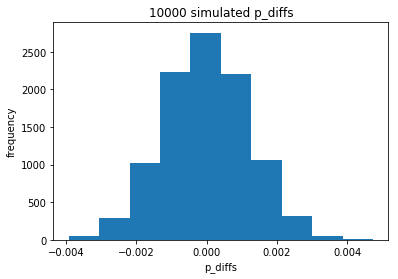

In [27]:
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('frequency')
plt.title('10000 simulated p_diffs');

According to the Central Limit Theorem, the sample distribution of the difference of the mean is normally distributed. So this histogram looks consistent.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
obs_diff = df2.query('group == "treatment"')['converted'].mean() - df2.query('group == "control"')['converted'].mean()
obs_diff

-0.0015782389853555567

In [29]:
(p_diffs > obs_diff).mean()

0.90580000000000005

Approximately *90%* of p_diffs are greater than the actual difference observed.

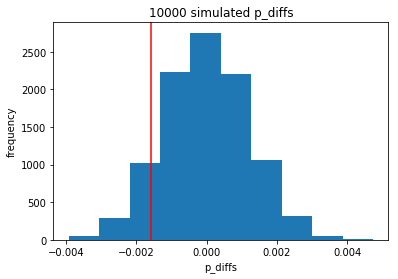

In [30]:
plt.hist(p_diffs)
plt.axvline(x=obs_diff, color='r')
plt.xlabel('p_diffs')
plt.ylabel('frequency')
plt.title('10000 simulated p_diffs');

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The value computed here is the **p-value** : the probability of observing our statistic (or one more extreme in favor of the alternative) is the null hypothesis is true.

The p-value is approximately **0.90**. With a level of $\alpha = 0.05$ (meaning that we have a 5% chance of committing a Type I error if the null is true), we fail to reject the null and we are not be able to provide statistical significance. Thus we cannot conclude that the new page provide better results than the old page.

**Built in t-test**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm

convert_old = sum(df2.query('group == "control"')['converted'])
convert_new = sum(df2.query('group == "treatment"')['converted'])
n_old = df2.query('group == "control"').shape[0]
n_new = df2.query('group == "treatment"').shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [32]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [33]:
from scipy.stats import norm
# 95% confidence level
norm.ppf(0.05)

-1.6448536269514729

The computed z-score of -1.31 is bigger than -1.64, the z-score associated with 5%, meaning that we fail to reject the null which suggest that the conversion rate of the old page is higher or equal to the conversion rate of the new page. The p-value is approximately the same as before. The z-score and p-value agree with the findings in parts j. and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

We should use a **logistic regression**.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
df2['intercept']=1

df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

df2.head(3)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [35]:
import statsmodels.api as sm

# instantiate and fit
logit = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
res = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 28 Feb 2019   Pseudo R-squ.:               8.077e-06
Time:                        18:02:57   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

The p-value associated with *ab_page* is **0.190**. It is still over the level $\alpha = 0.05$, so we still fail to reject the null hypothesis. It differs from the value found in part II as we are now in a **two-sided** test while in part II we were in a one-sided test.

The null and alternative hypotheses associated with our regression model are indeed :
$$H_0 : p_{new} = p_{old} $$
$$H_1 : p_{new} \neq p_{old} $$

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

It is a good idea to consider other factors as it can prevent bias results due to factors like change aversion and novelty effect.

However by adding more factors into the regression model, it might become harder to interpret the logistic regression model.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

First, we read the dataset :

In [37]:
countries_df = pd.read_csv('countries.csv')
countries_df.head(3)

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK


Then we merge our datasets together :

In [38]:
df_merged = df2.merge(countries_df, left_on='user_id', right_on='user_id', how='inner').set_index('user_id')
df_merged.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country
user_id,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [39]:
df_merged['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

We can see that the dataset is mainly composed of US users, followed by UK users and then CA users.

In [40]:
# dummy variable
df_merged[['CA', 'UK', 'US']] = pd.get_dummies(df_merged['country'])
df_merged.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
user_id,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [41]:
# instanciate and fit
logit_2 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'US', 'CA']])
res = logit_2.fit()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [42]:
# summary
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Thu, 28 Feb 2019   Pseudo R-squ.:               1.521e-05
Time:                        18:02:59   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
US            -0.0099      0.013     -0.746      0.456      -0.036       0.016
CA            -0.0507      0.028     -1.786      0.074      -0.106       0.005
==============================================================================
"""

The p-value for US and CA are over the level $\alpha = 0.05$, so we fail to reject the null hypothesis and we cannot provide evidences that the country influences the conversion rate.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [43]:
# dummy variables
df_merged['US_page'] = df_merged['US'] * df_merged['ab_page']
df_merged['CA_page'] = df_merged['CA'] * df_merged['ab_page']
df_merged.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,US_page,CA_page
user_id,,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,1,0
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,1,0
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0


In [44]:
# instanciate and fit
logit_3 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'US', 'CA', 'US_page', 'CA_page']])
res = logit_3.fit()

# summary
res.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 28 Feb 2019   Pseudo R-squ.:               3.482e-05
Time:                        18:03:00   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
US             0.0057      0.019      0.306      0.760      -0.031       0.043
CA            -0.0118      0.040     -0.296      0.767      -0.090       0.066
US_page       -0.0314      0.027     -1.181      0.238      -0.084       0.021
CA_page       -0.0783      0.057     -1.378      0.168      -0.190       0.033
==============================================================================
"""

According to this summary, the p-values are all over the level $\alpha = 0.05$, so we fail to reject the null hypothesis and we cannot provide evidences that an interation between page and country predicting wether a user converts or not exists.

<a id='conclusions'>CONCLUSION</a>

As a conclusion, we fail to reject the null hypothesis, therefore we do not have evidences that the new page results in more conversions thant the old page.

In [48]:
# save notebook as html
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0